# Differential Intelligence
(by Dario Izzo)

In this notebook we lay down the basic idea behind "differential intelligence", that is the use of high order derivatives in machine learning

## Importing stuff


In [1]:
from pyaudi import gdual_double as gdual
from pyaudi import sin, cos, tan
from random import random
from matplotlib import pyplot as plt
%matplotlib inline

## Controller representation and "simulator"
Take as an example the task of learning a robotic controller. In neuro evolution (or Evolutionary Robotics), the controller is typically represented by a neural network, but for the purpose of explaining this new learning concept we will use a polinomial representation for the controller. Later, changing the controller into a NN with weights as parameters will not change the essence of what is done here.

In [2]:
# Definition of the controller in terms of some weights parameters
def u(state, weights):
    x,v = state
    a,b,c,e,f,g = weights
    return a + b*x + c*v + e*x*v + f*x**2 + g*v**2

In [3]:
# Definition of the equation of motion (our physics simulator propagating the system to its next state)
def eom(state, weights):
    x,v = state
    dx = v
    dv = u(state, weights)
    return (dx, dv)

## The Euler Propagation
In Evolutionary Robotics Euler propagators are commonly used. The essence of what is done here would not change the if we code a Newton Raphson or a better method.

In [4]:
# The weights are all generalized duals
weights = [gdual(0.2*(random()-0.5), _, 4) for _ in "abcefg"]
x = [gdual(2*(random()-0.5))]
v = [gdual(2*(random()-0.5))]
dt = 0.1
# We propagate for 10 seconds (cannot oincrease this much as the control is polynomial thus x**2 and v**2 would make u1 biiiig)
for i in range(100):
    dx, dv = eom([x[-1],v[-1]], weights)
    x.append(x[-1] + dt * dx)
    v.append(v[-1] + dt * dv)

NOTE: the resulting points are gdual, they contain information on how the state reached by our "robot" changes if we change the control weights!!

In [5]:
x[0], x[-1]

(0.309729,
 -87.5171*db*dc*df+297.88*dc*df*dg-154.116*da*dc**2+79.3569*dc*df+2474.95*db*dc*df*dg+24164.4*db*df**3+640.084*de*df*dg**2+2253.7*da**2*de**2+282.832*db*de**2-80.4944*de**2*dg+5.67697*db**2+6491.1*da*df**2*dg+49.6749*da*de*df**2+43.0813*dc**2*df-83.068*da*db**2+1520.98*dc**2*df*dg-1910.19*db*dc**2*df-1715.38*da**2*db*dc-995.404*da**2*db**2-119.649*de**3+...)

In [6]:
v[0],v[-1]

(-0.294666,
 -390.009*db*dc*df+158.987*dc*df*dg-120.352*da*dc**2-23.4238*dc*df+577.104*db*dc*df*dg+4984.88*db*df**3-257.731*de*df*dg**2-669.141*da**2*de**2+375.522*db*de**2+10.2758*de**2*dg+10.3176*db**2+5799.32*da*df**2*dg+24280.3*da*de*df**2+128.821*dc**2*df+74.0659*da*db**2-46.6656*dc**2*df*dg-386.135*db*dc**2*df+939.824*da**2*db*dc-116.105*da**2*db**2-131.728*de**3+...)

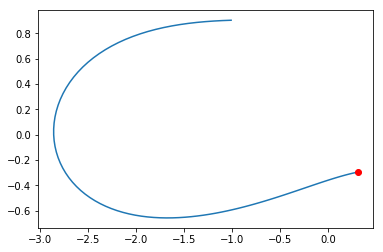

In [7]:
plt.plot([it.constant_cf for it in x],[it.constant_cf for it in v])
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.show()

In [8]:
xf, vf = x[-1], v[-1]

In [9]:
xf.constant_cf

-1.0111055918281473

In [10]:
vf.constant_cf

0.9026672236603197

## Studying the effects of the weights on the behavior
We have represented all the robot behavior (x, v) as a polynomial function of the weights. So we now know what happens to the behaviour if we change the weights!! Lets see ... we only consider the final state, but the same can be done for all states before

In [11]:
dweights = dict({'da': -0.002, 'db': 0.003, 'dc': -0.02, 'de': 0.03, 'df': 0.02, 'dg': -0.01})
#Lets predict the new final position of our 'robot' if we change his controller as defined above
print("new xf: {}".format(xf.evaluate(dweights)))
print("new vf: {}".format(vf.evaluate(dweights)))

new xf: -0.7524686709396718
new vf: 0.6325559582894508


## Check that we learned the correct map
We now simulate again our behavior using the new weights to see where we end up to check if the prediction made after our differential learning is correct.

In [12]:
new_weights = [it + dweights['d' + it.symbol_set[0]] for it in weights] 

In [13]:
new_simulated_x = [x[0]]
new_simulated_v = [v[0]]
dt = 0.1
# We propagate for 10 seconds (cannot oincrease this much as the control is polynomial thus x**2 and v**2 would make u1 biiiig)
for i in range(100):
    dx, dv = eom([new_simulated_x[-1],new_simulated_v[-1]], new_weights)
    new_simulated_x.append(new_simulated_x[-1] + dt * dx)
    new_simulated_v.append(new_simulated_v[-1] + dt * dv)

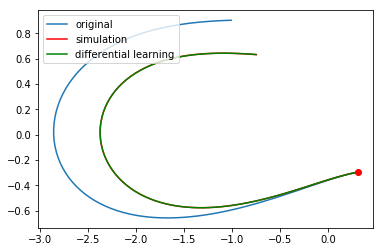

In [14]:
plt.plot([it.constant_cf for it in x],[it.constant_cf for it in v],label='original')
plt.plot([it.constant_cf for it in new_simulated_x],[it.constant_cf for it in new_simulated_v],'r',label='simulation')
plt.plot([it.evaluate(dweights) for it in x],[it.evaluate(dweights) for it in v],'g',label='differential learning')
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.legend(loc=2)
plt.show()

In [15]:
new_simulated_xf, new_simulated_vf = new_simulated_x[-1], new_simulated_v[-1]

In [16]:
new_simulated_xf.constant_cf

-0.7483217322326989

In [17]:
new_simulated_vf.constant_cf

0.6311539480420831

In [18]:
print("Differential learning xf: \t{}".format(xf.evaluate(dweights)))
print("Real xf: \t\t\t{}".format(new_simulated_xf.constant_cf))
print("Differential learning vf: \t{}".format(vf.evaluate(dweights)))
print("Real vf: \t\t\t{}".format(new_simulated_vf.constant_cf))

Differential learning xf: 	-0.7524686709396718
Real xf: 			-0.7483217322326989
Differential learning vf: 	0.6325559582894508
Real vf: 			0.6311539480420831
